In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from numba import jit
from matplotlib import pyplot as plt
import time
from datetime import timedelta
import pandas as pd
from collections import OrderedDict
from itertools import cycle
from typing import Optional, Tuple
from transformers import AutoTokenizer
from sentencepiece import SentencePieceProcessor
from datasets import load_dataset

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device_cap = torch.cuda.get_device_capability()
device_type = "cuda" if "cuda" in device else "cpu"
torch.cuda.set_device(device)
torch.manual_seed(8855)
print(torch.__version__)
print(device, device_cap)

C:\Users\chrisb\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.3.0
cuda:0 (8, 6)


### Llama 3 from Scratch

In [2]:
# Using Huggingface
tokenizer = AutoTokenizer.from_pretrained("./llama3/")
#tokenizer.add_special_tokens({"pad_token": "<PAD>"})
tokenizer.pad_token = tokenizer.eos_token #Optional

vocab = tokenizer.vocab

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
def encode(example):
    return tokenizer.encode(example, return_tensors="pt")


def decode(example):
    return tokenizer.batch_decode(
        example,
        skip_special_tokens=False,
        clean_up_tokenization_spaces=True,
    )[0]


print(f"Vocab Size: {len(vocab)}")
decode(
    encode(
        "hello I am a specifically designed long sentence to make sure this is working not only adequately, but good enough for our batch functions"
    )
)

Vocab Size: 128256


'<|begin_of_text|>hello I am a specifically designed long sentence to make sure this is working not only adequately, but good enough for our batch functions'

In [4]:
MASTER_CONFIG = {
    "vocab_size": len(vocab),
    "batch_size": 16,
    "context_window": 32,
    "d_model": 288,
    "epochs": 1000,
    "hidden_dim": 768,
    "log_interval": 50,
    "n_heads": 6,
    "n_layers": 6,
}

GLOBAL_KEEP_TRACK = []

In [5]:
# Local Data only
dataset = load_dataset(
    "text",
    data_files={
        "train": ["../../data/CombinedTinyStories-train.txt"],
        "val": ["../../data/CombinedTinyStories-valid.txt"],
    },
    streaming=True,
)

# Stream Data
# dataset = load_dataset('IMJONEZZ/CombinedTinyStories') # optional: streaming=True but to_iterable is faster
# dataset = dataset.to_iterable_dataset()

# Minimal preprocessing
clean_dataset = dataset.filter(lambda example: len(example["text"]) > 2)

In [6]:
prompt = "Write a short story. Possible Story: "
tokenized_prompt = tokenizer(prompt, return_tensors="pt").input_ids

encoded_dataset = clean_dataset.map(
    lambda examples: tokenizer(
        [prompt + x for x in examples["text"]],
        padding=True,
        return_tensors="pt",
    ),
    batched=True,
)
train_data = iter(encoded_dataset["train"].shuffle())
val_data = iter(encoded_dataset["val"].shuffle())
train_data = cycle(train_data)
val_data = cycle(val_data)

test = next(train_data)
print(f"Actual text: {test['text']}")
print(f"Input Ids: {tokenizer.decode(test['input_ids'])}")
print(f"Length of text: {len(test['input_ids'])}")
print(test)

Actual text: She started to crawl very slowly. After a while, she saw a small hole under the ground. She wondered what she will find there. She got very excited and started to crawl into the hole.
Input Ids: <|begin_of_text|>Write a short story. Possible Story: She started to crawl very slowly. After a while, she saw a small hole under the ground. She wondered what she will find there. She got very excited and started to crawl into the hole.<|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot

### Needed functions

In [7]:
# @torch.compile #For non-Windows users
def get_batches(
    data,
    batch_size,
    context_window,
    config=MASTER_CONFIG,
    debug=False,
):
    x = []
    y = []
    for _ in range(
        batch_size
    ):  # Adjust this lower if you're running out of memory
        batch_data = next(data)

        # pick random starting points
        ix = torch.randint(
            0, len(batch_data["input_ids"]) - context_window - 1, (2,)
        )
        batch_x = torch.stack(
            [batch_data["input_ids"][i : i + context_window] for i in ix]
        ).long()
        batch_y = torch.stack(
            [
                batch_data["input_ids"][i + 1 : i + context_window + 1]
                for i in ix
            ]
        ).long()
        x.append(batch_x)
        y.append(batch_y)
    x = torch.cat((x), 0).to(device)
    y = torch.cat((y), 0).to(device)
    if debug:
        print(f"ix: {ix}\nx: {x}\ny: {y}")
    return x, y


def get_lora_batches(
    data,
    batch_size,
    context_window=32,
):
    x = []
    y = []
    for _ in range(batch_size // 2):
        x_data = next(data)
        y_data = next(data)

        x_data = torch.stack([x_data["input_ids"]]).long()
        y_data = torch.stack([y_data["input_ids"]]).long()

        x.append(x_data)
        y.append(y_data)
    x = torch.cat((x), 0).to(device)
    y = torch.cat((y), 0).to(device)
    return x, y

xs, ys = get_batches(
                    train_data, 16, 32
                )
print(xs)
print(ys)

tensor([[  4024,    311,    279,  ..., 128009, 128009, 128009],
        [128009, 128009, 128009,  ..., 128009, 128009, 128009],
        [128009, 128009, 128009,  ..., 128009, 128009, 128009],
        ...,
        [128009, 128009, 128009,  ..., 128009, 128009, 128009],
        [ 56507,     13,   1102,  ..., 128009, 128009, 128009],
        [128009, 128009, 128009,  ..., 128009, 128009, 128009]],
       device='cuda:0')
tensor([[   311,    279,  36670,  ..., 128009, 128009, 128009],
        [128009, 128009, 128009,  ..., 128009, 128009, 128009],
        [128009, 128009, 128009,  ..., 128009, 128009, 128009],
        ...,
        [128009, 128009, 128009,  ..., 128009, 128009, 128009],
        [    13,   1102,    574,  ..., 128009, 128009, 128009],
        [128009, 128009, 128009,  ..., 128009, 128009, 128009]],
       device='cuda:0')


In [8]:
@torch.no_grad()
def get_loss(model, lora=False, config=MASTER_CONFIG):
    out = {}
    model.eval()
    for name, split in zip(["train", "val"], [train_data, val_data]):
        losses = []
        for _ in range(10):
            if lora == True:
                xb, yb = get_lora_batches(
                    split, config["batch_size"], config["context_window"]
                )
            else:
                xb, yb = get_batches(
                    split,
                    config["batch_size"],
                    config["context_window"],
                )
            _, loss = model(xb, yb)
            losses.append(loss.item())
        out[name] = np.mean(losses)
    model.train()
    return out


@torch.inference_mode()
def generate(
    model,
    config=MASTER_CONFIG,
    temperature=1.0,
    top_k=None,
    max_new_tokens=30,
    lora=False,
):
    idx_list = [tokenized_prompt] * 5
    idx = torch.cat((idx_list), 0).long().to(device)
    if lora:
        idx = (
            torch.ones(5, 1).long().to(device)
        )  # Alternative without prompt
    for _ in range(max_new_tokens):
        # call the model
        logits = model(idx[:, -config["context_window"] :])
        last_time_step_logits = logits[
            :, -1, :
        ]  # all the batches (1), last time step, all the logits

        last_time_step_logits = last_time_step_logits / temperature
        if top_k is not None:
            v, _ = torch.topk(
                last_time_step_logits,
                min(top_k, last_time_step_logits.size(-1)),
            )
            last_time_step_logits[last_time_step_logits < v[:, [-1]]] = (
                -float("Inf")
            )
        p = F.softmax(
            last_time_step_logits, dim=-1
        )  # softmax to get probabilities
        idx_next = torch.multinomial(
            p, num_samples=1
        )  # sample from the distribution to get the next token
        idx = torch.cat([idx, idx_next], dim=-1)  # append to the sequence
    return [tokenizer.decode(x) for x in idx.tolist()]

### Two-layer Feed Forward Network

In [9]:
class SimpleFeedForwardNN(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(
            config["vocab_size"], config["d_model"]
        )
        self.linear = nn.Sequential(
            nn.Linear(config["d_model"], config["d_model"]),
            nn.ReLU(),
            nn.Linear(config["d_model"], config["vocab_size"]),
        )

        print(
            f"model params: {sum([m.numel() for m in self.parameters()])}"
        )

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        logits = self.linear(x)

        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, self.config["vocab_size"]),
                targets.view(-1),
                ignore_index=tokenizer.pad_token_id,
                # reduction="sum",
            )
            return logits, loss

        else:
            return logits


model = SimpleFeedForwardNN(MASTER_CONFIG).to(device)
# opt_model = torch.compile(model) #Again, non-Windows folks should be compiling functions and models
# xs, ys = get_batches(
#     train_data,
#     MASTER_CONFIG["batch_size"],
#     MASTER_CONFIG["context_window"],
# )

# logits, loss = model(xs, ys)

model params: 74086944


### Training Loop

In [10]:
def train(
    model,
    optimizer,
    scheduler=None,
    data=None,
    config=MASTER_CONFIG,
    lora=False,
    print_logs=False,
):
    losses = []
    start_time = time.time()
    for epoch in range(config["epochs"]):
        try:
            optimizer.zero_grad()

            if lora:
                xs, ys = get_lora_batches(data, config["batch_size"])
            else:
                xs, ys = get_batches(
                    data, config["batch_size"], config["context_window"]
                )

            # #If you really want to overfit
            # for i in range(1, config["context_window"] + 1):
            #     x = xs[:i]
            #     y = ys[:i]
            #     logits, loss = model(x, targets=y)
            #     loss.backward()
            #     optimizer.step()

            logits, loss = model(xs, targets=ys)
            loss.backward()
            optimizer.step()

            if scheduler:
                scheduler.step()

            if epoch % config["log_interval"] == 0:
                batch_time = time.time() - start_time
                x = get_loss(model, lora=lora)
                losses += [x]
                if print_logs:
                    print(
                        f"Epoch {epoch} | train loss {x['train']:.3f} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA: {timedelta(seconds=(batch_time * (config['epochs'] - epoch)/config['log_interval']))}"
                    )
                start_time = time.time()

                if scheduler:
                    print("lr: ", scheduler.get_last_lr())
        except StopIteration:
            print(f"Reached end of dataset on step {epoch}")
            break

    GLOBAL_KEEP_TRACK.append(
        f"{type(model).__name__} {sum([m.numel() for m in model.parameters()])} Params | Train: {losses[-1]['train']:.3f} | Val: {losses[-1]['val']:.3f}"
    )
    print(
        f"training loss {losses[-1]['train']:.3f} | validation loss: {losses[-1]['val']:.3f}"
    )
    return pd.DataFrame(losses).plot(xlabel="Step // 50", ylabel="Loss")

Epoch 0 | train loss 11.704 | val loss 11.698 | Time 0.171 | ETA: 0:00:03.420005
Epoch 50 | train loss 6.399 | val loss 6.390 | Time 1.646 | ETA: 0:00:31.280589
Epoch 100 | train loss 5.720 | val loss 5.434 | Time 1.467 | ETA: 0:00:26.410343
Epoch 150 | train loss 5.451 | val loss 5.524 | Time 1.468 | ETA: 0:00:24.955614
Epoch 200 | train loss 4.470 | val loss 5.084 | Time 1.468 | ETA: 0:00:23.490887
Epoch 250 | train loss 5.153 | val loss 4.898 | Time 1.473 | ETA: 0:00:22.097218
Epoch 300 | train loss 4.876 | val loss 4.707 | Time 1.501 | ETA: 0:00:21.014039
Epoch 350 | train loss 4.849 | val loss 4.703 | Time 1.471 | ETA: 0:00:19.122990
Epoch 400 | train loss 4.891 | val loss 4.729 | Time 1.508 | ETA: 0:00:18.098242
Epoch 450 | train loss 4.742 | val loss 4.674 | Time 1.553 | ETA: 0:00:17.083577
Epoch 500 | train loss 4.815 | val loss 4.523 | Time 1.574 | ETA: 0:00:15.739756
Epoch 550 | train loss 4.702 | val loss 4.527 | Time 1.571 | ETA: 0:00:14.138276
Epoch 600 | train loss 4.520 

<Axes: xlabel='Step // 50', ylabel='Loss'>

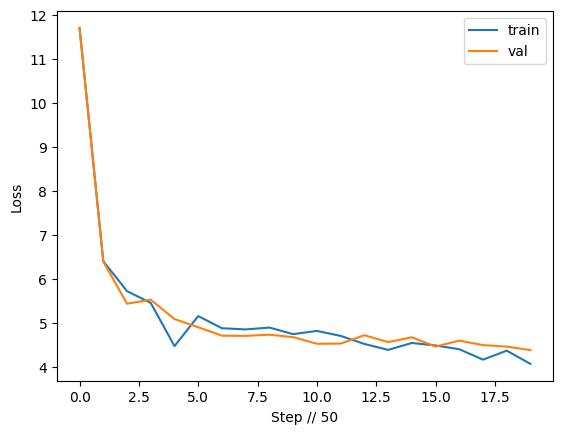

In [11]:
optimizer = torch.optim.AdamW(
    model.parameters(),
)
train(model, optimizer, data=train_data, print_logs=True)

In [12]:
generate(model, config=MASTER_CONFIG)

['<|begin_of_text|>Write a short story. Possible Story:  through the noticed. Possible Story: <|endoftext|> your. One day on some lots of the bear he had also before. He felt',
 '<|begin_of_text|>Write a short story. Possible Story:  sees the wind Giul good her close the lion!  see it was time, it. Possible Story: Once upon a short story. But go down',
 '<|begin_of_text|>Write a short story. Possible Story:  dive leaves, juice!" she couldn\'t to be from!" His mom and in the yard can find a dry, never bright yarn the harbor, after',
 '<|begin_of_text|>Write a short story. Possible Story:  one little car and big birthday. Her mommy said that it light. One day at the big smile. The duck felt proud of how to the bird',
 '<|begin_of_text|>Write a short story. Possible Story:  Aоду and always the cake. It cried. When and happiness her leaves and made her mom said, and went to the ε. isches Tim']

In [13]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

SimpleFeedForwardNN 74086944 Params | Train: 4.065 | Val: 4.380


### RMS Normalization

In [14]:
class RMSNormalization(torch.nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.register_parameter(
            "scale", nn.Parameter(torch.ones(dim))
        )

    def forward(self, x):
        output = x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
        return output * self.scale[: x.shape[1], :].unsqueeze(0)

model params: 74169888
Epoch 0 | train loss 11.754 | val loss 11.754 | Time 0.031 | ETA: 0:00:00.620003
Epoch 50 | train loss 6.209 | val loss 6.277 | Time 1.574 | ETA: 0:00:29.907112
Epoch 100 | train loss 5.396 | val loss 5.380 | Time 1.512 | ETA: 0:00:27.216315
Epoch 150 | train loss 5.233 | val loss 5.200 | Time 1.531 | ETA: 0:00:26.033333
Epoch 200 | train loss 5.279 | val loss 5.067 | Time 1.544 | ETA: 0:00:24.708130
Epoch 250 | train loss 4.840 | val loss 4.705 | Time 1.631 | ETA: 0:00:24.470365
Epoch 300 | train loss 4.690 | val loss 4.667 | Time 1.461 | ETA: 0:00:20.454310
Epoch 350 | train loss 4.899 | val loss 4.719 | Time 1.601 | ETA: 0:00:20.812040
Epoch 400 | train loss 4.631 | val loss 4.794 | Time 1.491 | ETA: 0:00:17.886698
Epoch 450 | train loss 4.740 | val loss 5.019 | Time 1.498 | ETA: 0:00:16.478308
Epoch 500 | train loss 4.768 | val loss 4.817 | Time 1.534 | ETA: 0:00:15.340574
Epoch 550 | train loss 4.610 | val loss 4.770 | Time 1.583 | ETA: 0:00:14.247135
Epoch 

<Axes: xlabel='Step // 50', ylabel='Loss'>

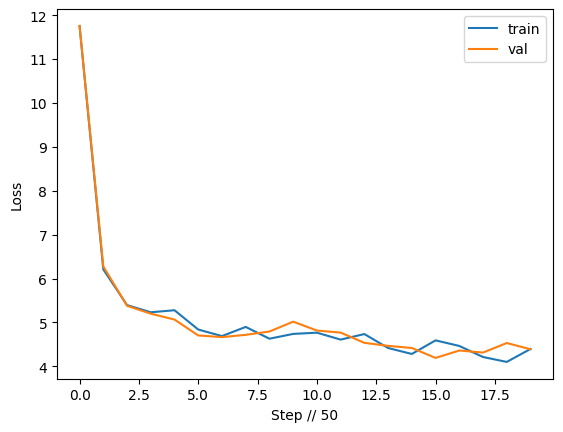

In [15]:
class SimpleFeedForwardNN_RMS(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(
            config["vocab_size"], config["d_model"]
        )
        self.rms = RMSNormalization((config["d_model"], config["d_model"]))
        self.linear = nn.Sequential(
            nn.Linear(config["d_model"], config["d_model"]),
            nn.ReLU(),
            nn.Linear(config["d_model"], config["vocab_size"]),
        )

        print(
            f"model params: {sum([m.numel() for m in self.parameters()])}"
        )

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        x = self.rms(x)  # rms pre-normalization
        logits = self.linear(x)

        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, self.config["vocab_size"]),
                targets.view(-1),
                ignore_index=tokenizer.pad_token_id,
                # reduction="sum",
            )
            return logits, loss

        else:
            return logits


model = SimpleFeedForwardNN_RMS(MASTER_CONFIG).to(device)
optimizer = torch.optim.AdamW(model.parameters())
train(model, optimizer, data=train_data, print_logs=True)

In [16]:
generate(model, config=MASTER_CONFIG)

['<|begin_of_text|>Write a short story. Possible Story: 3 were so he felt proud," saved lost have to see the!" asked for herself. He had a walk again, fades you help him?" new',
 '<|begin_of_text|>Write a short story. Possible Story:  off on,.Expr and_requests. Do you want anymore truck. I belong. Mary and was the flower fun. Possible Story: Suddenly day. So',
 '<|begin_of_text|>Write a short story. Possible Story: 3 Lily replied "If about the pond. 3 year more felt like-section near its kite and thought she did not to keep the top to be',
 '<|begin_of_text|>Write a short story. Possible Story: 3 to play with the distance back. It was more."  haveỹ. grateful and fairy, "You on his dad came back home. Possible',
 '<|begin_of_text|>Write a short story. Possible Story: 3 ever on the ground. Possible Story:, Lily. Owl. It was finally the faces. hungry another silly with the swings and proud of']

In [17]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

SimpleFeedForwardNN 74086944 Params | Train: 4.065 | Val: 4.380
SimpleFeedForwardNN_RMS 74169888 Params | Train: 4.397 | Val: 4.390


### RoPE scaling

In [18]:
def get_rotary_matrix(context_window, embedding_dim):
    R = torch.zeros(
        (context_window, embedding_dim, embedding_dim), requires_grad=False
    )
    for position in range(context_window):
        for i in range(embedding_dim // 2):
            theta = 10000.0 ** (-2.0 * (i - 1) / embedding_dim)
            m_theta = position * theta
            R[position, 2 * i, 2 * i] = np.cos(m_theta)
            R[position, 2 * i, 2 * i + 1] = -np.sin(m_theta)
            R[position, 2 * i + 1, 2 * i] = np.sin(m_theta)
            R[position, 2 * i + 1, 2 * i + 1] = np.cos(m_theta)
    return R

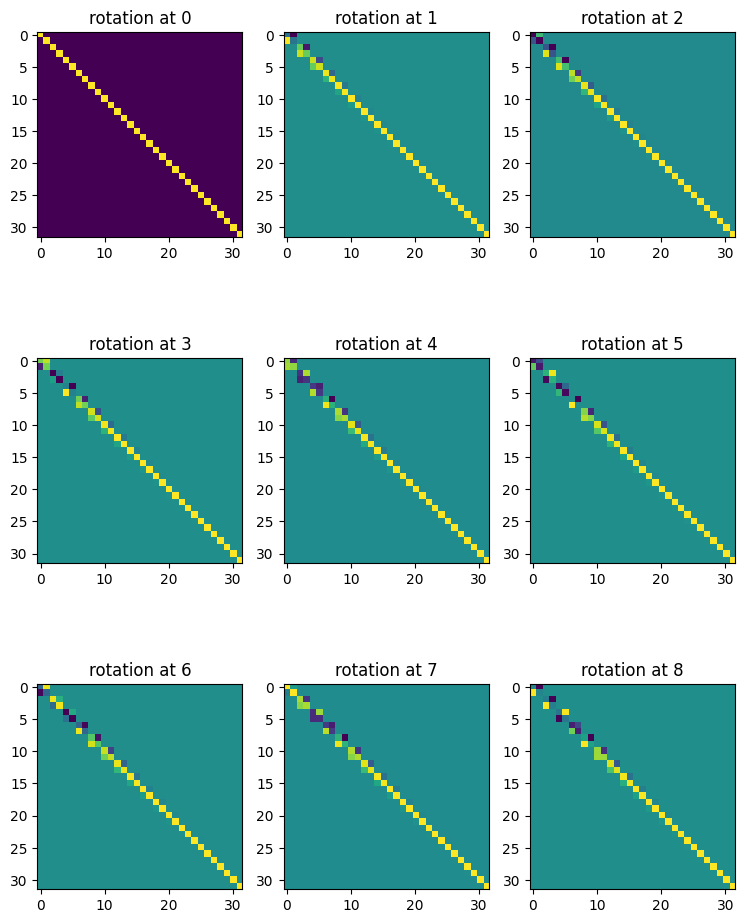

In [19]:
from IPython.display import clear_output

K = 3
config = {
    "batch_size": 10,
    "d_model": 32,
    "n_heads": 8,
    "context_window": K**2,
}
batch = torch.randn(1, config["context_window"], config["d_model"])
R = get_rotary_matrix(config["context_window"], config["d_model"])
# clear_output()
fig, ax = plt.subplots(K, K, figsize=(K * 3, K * 4))

for i in range(K):
    for j in range(K):
        ax[i, j].imshow(R[i * K + j, :, :].detach().numpy())
        ax[i, j].set_title(f"rotation at {i * K + j}")

In [20]:
config = {
    "batch_size": 10,
    "d_model": 512,
    "n_heads": 8,
    "context_window": 16,
}


class RoPEMaskedAttentionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.w_q = nn.Linear(
            config["d_model"], config["d_model"], bias=False
        )
        self.w_k = nn.Linear(
            config["d_model"], config["d_model"], bias=False
        )
        self.w_v = nn.Linear(
            config["d_model"], config["d_model"], bias=False
        )

        self.R = get_rotary_matrix(
            config["context_window"], config["d_model"]
        ).to(device)

    @jit(nopython=False)
    def get_rotary_matrix(context_window, embedding_dim):
        R = torch.zeros(
            (context_window, embedding_dim, embedding_dim),
            requires_grad=False,
        )
        for position in range(context_window):
            for i in range(embedding_dim // 2):
                theta = 10000.0 ** (-2.0 * (i - 1) / embedding_dim)
                m_theta = position * theta
                R[position, 2 * i, 2 * i] = np.cos(m_theta)
                R[position, 2 * i, 2 * i + 1] = -np.sin(m_theta)
                R[position, 2 * i + 1, 2 * i] = np.sin(m_theta)
                R[position, 2 * i + 1, 2 * i + 1] = np.cos(m_theta)
        return R

    def forward(self, x, return_attn_weights=False):
        b, m, d = x.shape

        q = self.w_q(x).to(device)
        k = self.w_k(x).to(device)
        v = self.w_v(x).to(device)

        q_rotated = (
            (torch.bmm(q.transpose(0, 1), self.R[:m]))
            .transpose(0, 1)
            .to(device)
        )
        k_rotated = (
            (torch.bmm(k.transpose(0, 1), self.R[:m]))
            .transpose(0, 1)
            .to(device)
        )

        activations = F.scaled_dot_product_attention(
            q_rotated, k_rotated, v, dropout_p=0.1, is_causal=True
        )

        if return_attn_weights:
            attn_mask = torch.tril(torch.ones((m, m)), diagonal=0).to(
                device
            )
            attn_weights = (
                torch.bmm(q_rotated, k_rotated.transpose(1, 2)) / np.sqrt(d)
                + attn_mask
            )
            attn_weights = F.softmax(attn_weights, dim=-1)
            return activations, attn_weights
        return activations


layer = RoPEMaskedAttentionHead(config)
batch = torch.randn(
    (config["batch_size"], config["context_window"], config["d_model"])
)
output, attn_weights = layer(batch, return_attn_weights=True)

C:\Users\chrisb\AppData\Local\Temp\ipykernel_21928\2521293711.py:61: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  activations = F.scaled_dot_product_attention(


In [21]:
class RoPEMaskedMultiheadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.heads = nn.ModuleList(
            [
                RoPEMaskedAttentionHead(config).to(device)
                for _ in range(config["n_heads"])
            ]
        )
        self.linear = nn.Linear(
            config["n_heads"] * config["d_model"], config["d_model"]
        ).to(device)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = x.to(device)
        heads = [h(x) for h in self.heads]
        x = torch.cat(heads, dim=-1)
        x = self.linear(x)
        x = self.dropout(x)
        return x


layer = RoPEMaskedMultiheadAttention(MASTER_CONFIG)
batch = torch.ones(
    (
        MASTER_CONFIG["batch_size"],
        MASTER_CONFIG["context_window"],
        MASTER_CONFIG["d_model"],
    )
)
output = layer(batch)
output.shape

torch.Size([16, 32, 288])

model params: 76160832
Epoch 0 | train loss 11.822 | val loss 11.823 | Time 0.009 | ETA: 0:00:00.180016
Epoch 50 | train loss 5.943 | val loss 5.686 | Time 1.808 | ETA: 0:00:34.343413
Epoch 100 | train loss 5.556 | val loss 5.500 | Time 1.837 | ETA: 0:00:33.057630
Epoch 150 | train loss 4.959 | val loss 5.318 | Time 1.813 | ETA: 0:00:30.817996
Epoch 200 | train loss 4.818 | val loss 4.957 | Time 1.829 | ETA: 0:00:29.271080
Epoch 250 | train loss 4.581 | val loss 4.893 | Time 1.783 | ETA: 0:00:26.748118
Epoch 300 | train loss 4.276 | val loss 4.925 | Time 1.812 | ETA: 0:00:25.370197
Epoch 350 | train loss 4.517 | val loss 4.465 | Time 1.791 | ETA: 0:00:23.278889
Epoch 400 | train loss 4.609 | val loss 4.510 | Time 1.819 | ETA: 0:00:21.833416
Epoch 450 | train loss 4.369 | val loss 4.582 | Time 1.872 | ETA: 0:00:20.596526
Epoch 500 | train loss 4.020 | val loss 4.275 | Time 1.857 | ETA: 0:00:18.568640
Epoch 550 | train loss 4.120 | val loss 4.344 | Time 1.817 | ETA: 0:00:16.354074
Epoch 

<Axes: xlabel='Step // 50', ylabel='Loss'>

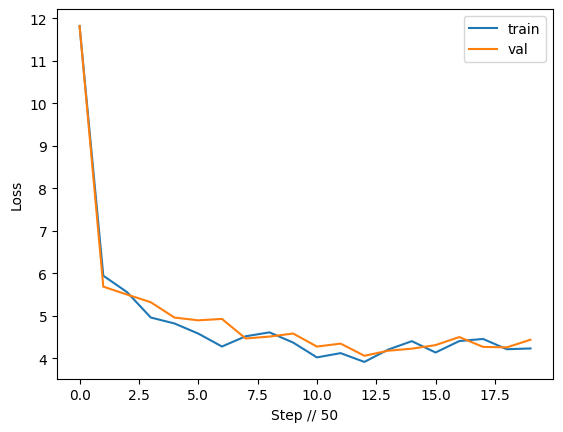

In [22]:
class SimpleFeedForwardNN_RMS_Rope(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(
            config["vocab_size"], config["d_model"]
        )
        self.rms = RMSNormalization(
            (config["d_model"], config["d_model"])
        ).to(device)
        self.rope_attention = RoPEMaskedMultiheadAttention(config).to(
            device
        )

        self.linear = nn.Sequential(
            nn.Linear(config["d_model"], config["d_model"]), nn.ReLU()
        )

        self.last_linear = nn.Linear(
            config["d_model"], config["vocab_size"]
        )

        print(
            f"model params: {sum([m.numel() for m in self.parameters()])}"
        )

    def forward(self, idx, targets=None):
        x = self.embedding(idx)

        x = self.rms(x)
        x = x + self.rope_attention(x)

        x = self.rms(x)
        x = x + self.linear(x)

        logits = self.last_linear(x)

        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, self.config["vocab_size"]),
                targets.view(-1),
                ignore_index=tokenizer.pad_token_id,
                # reduction="sum",
            )
            return logits, loss

        else:
            return logits


model = SimpleFeedForwardNN_RMS_Rope(MASTER_CONFIG).to(device)
optimizer = torch.optim.AdamW(model.parameters())
train(model, optimizer, data=train_data, print_logs=True)

In [23]:
generate(model, config=MASTER_CONFIG)

['<|begin_of_text|>Write a short story. Possible Story: 3 years old cow and went home to the store." He ran around, he watched his things, and he picked up the loud and used the words',
 '<|begin_of_text|>Write a short story. Possible Story: 3 around her hand and said, "Good cat. Together at the mess. Let\'s go to do! Tim was so happy, then on the',
 "<|begin_of_text|>Write a short story. Possible Story: 3 worry. She saw something enough in her their camp and to be good friends. She didn't so he heard his eyes lit trust it was a",
 '<|begin_of_text|>Write a short story. Possible Story: 3 years old out of the sky everything for specialing again:,. Just she loved to play with. She closed her life said, "Don',
 '<|begin_of_text|>Write a short story. Possible Story: 3ly, he opened it. So the apple and ran around. He was scared, and then pokingie to respect to paper and out. He']

In [24]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

SimpleFeedForwardNN 74086944 Params | Train: 4.065 | Val: 4.380
SimpleFeedForwardNN_RMS 74169888 Params | Train: 4.397 | Val: 4.390
SimpleFeedForwardNN_RMS_Rope 76160832 Params | Train: 4.230 | Val: 4.436


### SwiGLU

In [25]:
class SwiGLU(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.config = config
        self.linear_gate = nn.Linear(size, size)
        self.linear = nn.Linear(size, size)
        self.beta = torch.randn(1, requires_grad=True)

        self.beta = nn.Parameter(torch.ones(1))
        self.register_parameter("beta", self.beta)

    def forward(self, x):
        swish_gate = self.linear_gate(x) * torch.sigmoid(
            self.beta * self.linear_gate(x)
        )
        out = swish_gate * self.linear(x)
        return out

model params: 76327297
Epoch 0 | train loss 11.818 | val loss 11.812 | Time 0.030 | ETA: 0:00:00.599995
Epoch 50 | train loss 5.891 | val loss 6.228 | Time 1.844 | ETA: 0:00:35.038919
Epoch 100 | train loss 4.932 | val loss 5.736 | Time 1.854 | ETA: 0:00:33.376280
Epoch 150 | train loss 4.788 | val loss 5.661 | Time 1.865 | ETA: 0:00:31.712438
Epoch 200 | train loss 5.032 | val loss 5.226 | Time 1.860 | ETA: 0:00:29.767906
Epoch 250 | train loss 4.863 | val loss 4.754 | Time 1.834 | ETA: 0:00:27.512859
Epoch 300 | train loss 4.693 | val loss 4.736 | Time 1.843 | ETA: 0:00:25.798257
Epoch 350 | train loss 4.540 | val loss 4.906 | Time 1.853 | ETA: 0:00:24.085360
Epoch 400 | train loss 4.524 | val loss 4.457 | Time 1.854 | ETA: 0:00:22.251163
Epoch 450 | train loss 4.545 | val loss 4.638 | Time 1.823 | ETA: 0:00:20.048882
Epoch 500 | train loss 4.533 | val loss 4.769 | Time 1.850 | ETA: 0:00:18.500023
Epoch 550 | train loss 4.316 | val loss 4.418 | Time 1.864 | ETA: 0:00:16.779161
Epoch 

<Axes: xlabel='Step // 50', ylabel='Loss'>

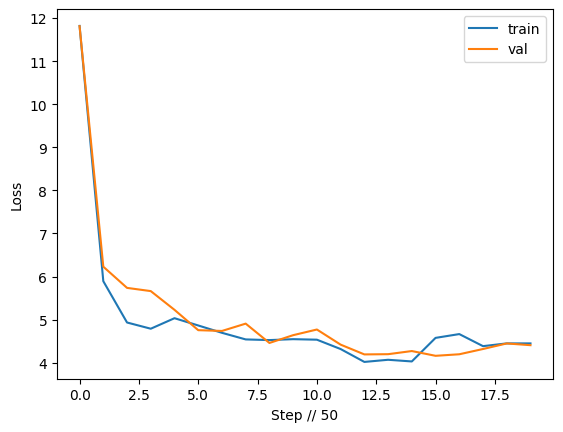

In [26]:
class SimpleFeedForwardNN_RMS_RoPE_SwiGLU(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(
            config["vocab_size"], config["d_model"]
        )
        self.rms = RMSNormalization((config["d_model"], config["d_model"]))
        self.rope_attention = RoPEMaskedMultiheadAttention(config)

        self.linear = nn.Sequential(
            nn.Linear(config["d_model"], config["d_model"]),
            SwiGLU(config["d_model"]),
        )

        self.last_linear = nn.Linear(
            config["d_model"], config["vocab_size"]
        )

        print(
            f"model params: {sum([m.numel() for m in self.parameters()])}"
        )

    def forward(self, idx, targets=None):
        x = self.embedding(idx)

        x = self.rms(x)
        x = x + self.rope_attention(x)

        x = self.rms(x)
        x = x + self.linear(x)

        logits = self.last_linear(x)

        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, self.config["vocab_size"]),
                targets.view(-1),
                ignore_index=tokenizer.pad_token_id,
                # reduction="sum",
            )
            return logits, loss

        else:
            return logits


model = SimpleFeedForwardNN_RMS_RoPE_SwiGLU(MASTER_CONFIG).to(device)
optimizer = torch.optim.AdamW(model.parameters())
train(model, optimizer, data=train_data, print_logs=True)

In [27]:
generate(model, config=MASTER_CONFIG)

["<|begin_of_text|>Write a short story. Possible Story: 3 year toy. He wanted to eat of the crab boy. He wouldn't dogs on the spear playing up and ran to play together. That someone",
 '<|begin_of_text|>Write a short story. Possible Story: 3 hat She said, "Sam. My agreement smells a party if you did that feeling sad clothes andKen ready and landed it up a sign I',
 '<|begin_of_text|>Write a short story. Possible Story:  wandered”. "Oh the sadness and the puppymy! They stopped and did not care about and let\'s you happy. What in the kitchen. Suddenly',
 "<|begin_of_text|>Write a short story. Possible Story: 3 tea happily asked if he came from it got scared. He saw the treasure. by flew away and he suddenly's easily这 in the door.",
 '<|begin_of_text|>Write a short story. Possible Story:  mommy and Mil! Let!” \'d nearby, something. Jake wasabel will pay crawl pop, "Don\'t· of their home. Come,']

In [28]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

SimpleFeedForwardNN 74086944 Params | Train: 4.065 | Val: 4.380
SimpleFeedForwardNN_RMS 74169888 Params | Train: 4.397 | Val: 4.390
SimpleFeedForwardNN_RMS_Rope 76160832 Params | Train: 4.230 | Val: 4.436
SimpleFeedForwardNN_RMS_RoPE_SwiGLU 76327297 Params | Train: 4.447 | Val: 4.406


In [29]:
del model
with torch.no_grad():
    torch.cuda.empty_cache()
import gc

gc.collect()

76

### Llama

In [30]:
class LlamaBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.rms = RMSNormalization(
            (config["d_model"], config["d_model"])
        )

        self.attention = RoPEMaskedMultiheadAttention(config).to(device)
        self.feedforward = nn.Sequential(
            nn.Linear(config["d_model"], config["hidden_dim"]),
            SwiGLU(config["hidden_dim"]),
            nn.Linear(config["hidden_dim"], config["d_model"]),
        )

    def forward(self, x):
        h = x + self.attention(self.rms(x))
        out = h + self.feedforward(self.rms(x))
        return out

In [31]:
class SimpleLlama(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(
            config["vocab_size"], config["d_model"]
        )
        self.llama_blocks = nn.Sequential(
            OrderedDict(
                [
                    (f"llama_{i}", LlamaBlock(config).to(device))
                    for i in range(config["n_layers"])
                ]
            )
        )

        self.ffn = nn.Sequential(
            nn.Linear(config["d_model"], config["d_model"]),
            SwiGLU(config["d_model"]),
            nn.Linear(config["d_model"], config["vocab_size"]),
        )

        print(
            f"model params: {sum([m.numel() for m in self.parameters()])}"
        )

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        x = self.llama_blocks(x)
        logits = self.ffn(x)

        if targets is None:
            return logits

        else:
            loss = F.cross_entropy(
                logits.view(-1, self.config["vocab_size"]),
                targets.view(-1),
                ignore_index=tokenizer.pad_token_id,
                # reduction="sum",
            )
            return logits, loss

model params: 96444391
Epoch 0 | train loss 11.717 | val loss 11.719 | Time 0.041 | ETA: 0:00:00.819998
Epoch 50 | train loss 7.363 | val loss 7.447 | Time 3.670 | ETA: 0:01:09.730735
Epoch 100 | train loss 5.604 | val loss 5.928 | Time 3.580 | ETA: 0:01:04.439299
Epoch 150 | train loss 5.199 | val loss 5.945 | Time 3.578 | ETA: 0:01:00.824968
Epoch 200 | train loss 5.041 | val loss 5.507 | Time 3.573 | ETA: 0:00:57.175953
Epoch 250 | train loss 4.712 | val loss 5.194 | Time 3.671 | ETA: 0:00:55.070958
Epoch 300 | train loss 4.865 | val loss 5.428 | Time 3.604 | ETA: 0:00:50.455961
Epoch 350 | train loss 4.754 | val loss 5.201 | Time 3.534 | ETA: 0:00:45.936315
Epoch 400 | train loss 4.357 | val loss 4.902 | Time 3.601 | ETA: 0:00:43.209140
Epoch 450 | train loss 4.024 | val loss 4.651 | Time 3.517 | ETA: 0:00:38.685541
Epoch 500 | train loss 4.280 | val loss 4.358 | Time 3.522 | ETA: 0:00:35.219376
Epoch 550 | train loss 4.164 | val loss 4.408 | Time 3.542 | ETA: 0:00:31.881451
Epoch 

<Axes: xlabel='Step // 50', ylabel='Loss'>

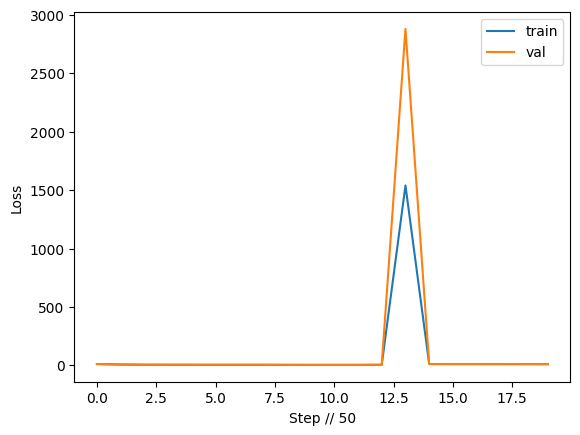

In [32]:
llama = SimpleLlama(MASTER_CONFIG).to(device)
optimizer = torch.optim.AdamW(llama.parameters())
train(
    llama, optimizer, data=train_data, config=MASTER_CONFIG, print_logs=True
)

This is why you need a scheduler lol

In [33]:
generate(
    llama,
    config=MASTER_CONFIG,
    temperature=1.0,
    top_k=25,
    max_new_tokens=50,
)

['<|begin_of_text|>Write a short story. Possible Story:  The happy happy her: the. They she on, with she Lily\'t Possible was day " she\'t her to it Possible Possible on story Lily and day and a Possible with,. on said said said a Possible the happy it on and " and',
 '<|begin_of_text|>Write a short story. Possible Story:,. to was she so with happy a was., Possible it she in with was story she The so it\'t was she: story day " she so and the\'t Lily: The a Possible. in\'t.. her day Possible was Possible',
 '<|begin_of_text|>Write a short story. Possible Story:  with was so a it: The. the: Possible said. she Possible it said, Lily the said in in said day Possible she They on and Possible said Lily.. and she on story to it\'t. on was, she happy on "',
 "<|begin_of_text|>Write a short story. Possible Story: : in Lily so a day happy a,: and with, with day day and so on in on so story day a with was she was the with in Possible to the and't she, her day happy happy to a day with: said a",
 

In [34]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

SimpleFeedForwardNN 74086944 Params | Train: 4.065 | Val: 4.380
SimpleFeedForwardNN_RMS 74169888 Params | Train: 4.397 | Val: 4.390
SimpleFeedForwardNN_RMS_Rope 76160832 Params | Train: 4.230 | Val: 4.436
SimpleFeedForwardNN_RMS_RoPE_SwiGLU 76327297 Params | Train: 4.447 | Val: 4.406
SimpleLlama 96444391 Params | Train: 10.828 | Val: 10.832


In [35]:
#MASTER_CONFIG['epochs'] = 52171228 // MASTER_CONFIG['batch_size'] # If you want to do a full epoch
MASTER_CONFIG['epochs'] = 1000
MASTER_CONFIG["batch_size"] = 16
MASTER_CONFIG["d_model"] = 768
MASTER_CONFIG["n_layers"] = 8
MASTER_CONFIG["context_window"] = 64

llama = SimpleLlama(MASTER_CONFIG).to(device)

llama_optimizer = torch.optim.AdamW(
    llama.parameters(),
    betas=(0.9, 0.95),
    weight_decay=1e-1,
    eps=1e-9,
    lr=5e-4,
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    llama_optimizer, 1000, eta_min=1e-5
)

model params: 335771145


Epoch 0 | train loss 11.745 | val loss 11.743 | Time 0.060 | ETA: 0:00:01.199417
lr:  [0.0004999987909744553]
Epoch 50 | train loss 6.294 | val loss 6.386 | Time 18.106 | ETA: 0:05:44.016712
lr:  [0.0004968620434287298]
Epoch 100 | train loss 5.744 | val loss 5.894 | Time 17.353 | ETA: 0:05:12.358183
lr:  [0.00048776984967968684]
Epoch 150 | train loss 5.470 | val loss 5.662 | Time 17.484 | ETA: 0:04:57.229426
lr:  [0.0004729460897126908]
Epoch 200 | train loss 5.416 | val loss 5.306 | Time 17.736 | ETA: 0:04:43.776600
lr:  [0.0004527557736953662]
Epoch 250 | train loss 5.384 | val loss 5.176 | Time 18.243 | ETA: 0:04:33.650908
lr:  [0.0004276960542158767]
Epoch 300 | train loss 5.007 | val loss 5.215 | Time 17.817 | ETA: 0:04:09.435142
lr:  [0.00039838398473624826]
Epoch 350 | train loss 4.877 | val loss 5.122 | Time 17.188 | ETA: 0:03:43.438129
lr:  [0.00036554132568825045]
Epoch 400 | train loss 4.720 | val loss 4.895 | Time 16.902 | ETA: 0:03:22.828980
lr:  [0.0003299767723361813]


<Axes: xlabel='Step // 50', ylabel='Loss'>

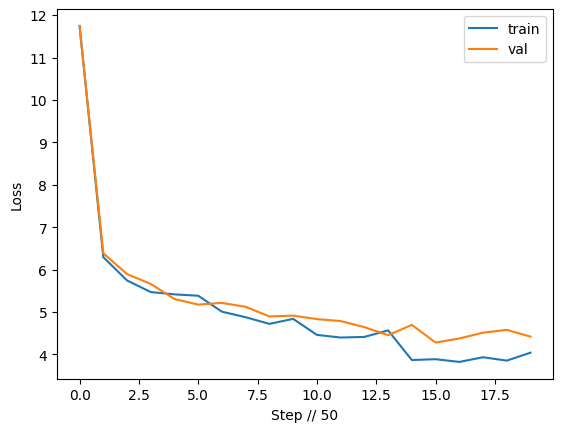

In [36]:
train(
    llama,
    llama_optimizer,
    scheduler=scheduler,
    data=train_data,
    config=MASTER_CONFIG,
    print_logs=True,
)

In [37]:
generate(
    llama,
    config=MASTER_CONFIG,
    temperature=1.0,
    top_k=5,
    max_new_tokens=50,
)

["<|begin_of_text|>Write a short story. Possible Story:  one day, and a big little girl was happy. She saw a short named Bob and decided to make a time. Then she would hug around, the mouse couldn't eat her car. She had a great day on the whole face and her mom",
 "<|begin_of_text|>Write a short story. Possible Story:, a big small boy and the boat to the floor. They took the boy with the tree to the birds. They pulled over the forest made the sky. Then you told each other. Can's not know what you play to buy them. And",
 "<|begin_of_text|>Write a short story. Possible Story:  the shore was very yummy and soft. She wanted to be careful and run with her toys. She didn't want to be careful! But Ben wanted to stay the box with herself to help. Anna lived that his friend was fun.  what was",
 '<|begin_of_text|>Write a short story. Possible Story:  not you sorry and her, he did not want to help you play the flower. He learned to him you playing with a pretty again. He enjoyed a pretty." She 

In [38]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

SimpleFeedForwardNN 74086944 Params | Train: 4.065 | Val: 4.380
SimpleFeedForwardNN_RMS 74169888 Params | Train: 4.397 | Val: 4.390
SimpleFeedForwardNN_RMS_Rope 76160832 Params | Train: 4.230 | Val: 4.436
SimpleFeedForwardNN_RMS_RoPE_SwiGLU 76327297 Params | Train: 4.447 | Val: 4.406
SimpleLlama 96444391 Params | Train: 10.828 | Val: 10.832
SimpleLlama 335771145 Params | Train: 4.042 | Val: 4.420


# Quantization

In [39]:
llama.to("cpu")
qconfig_dict = {
    torch.nn.Embedding: torch.quantization.float_qparams_weight_only_qconfig,
    torch.nn.Linear: torch.quantization.default_dynamic_qconfig,
}
# Post Training Dynamic Quantization
dynamic_quantized_llama = torch.quantization.quantize_dynamic(
    llama, qconfig_dict, dtype=torch.qint8
)


# Get Size difference
def get_param_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    return param_size


def get_buffer_size(model):
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    return buffer_size


def get_param_and_buffer_size(model):
    param_size = get_param_size(model)
    buffer_size = get_buffer_size(model)
    return param_size, buffer_size


def get_size_difference(models: list) -> str:
    keeping_track = []
    for idx, model in enumerate(models):
        param_size, buffer_size = get_param_and_buffer_size(model)
        size_all_mb = (param_size + buffer_size) / 1024**2
        keeping_track.append(
            f"{type(model).__name__} size: {size_all_mb:.3f}MB"
        )
    return keeping_track


list_of_sizes = get_size_difference([llama, dynamic_quantized_llama])
for size in list_of_sizes:
    print(size)

SimpleLlama size: 1280.865MB
SimpleLlama size: 18.000MB


# LoRA

If you have this:

<p>def forward(self, x):<br>
    x = self.linear_1(x)<br>
    x = F.relu(x)<br>
    x = self.linear_2(x)<br>
    return x<br></p>

change it to this:

<p>def forward(self, x):<br>
    x = self.linear_1(x) + self.lora_1(x)<br>
    x = F.relu(x)<br>
    x = self.linear_2(x) + self.lora_2(x)<br>
    return logits<br></p>

In [40]:
class LoRALayer(nn.Module):
    def __init__(self, in_dim, out_dim, rank, alpha):
        super().__init__()
        standard_deviation = 1 / torch.sqrt(torch.tensor(rank).float())
        self.A = nn.Parameter(
            torch.randn(in_dim, rank) * standard_deviation
        )
        self.B = nn.Parameter(torch.zeros(rank, out_dim))
        self.alpha = alpha

    def forward(self, x):
        x = self.alpha * (x @ self.A @ self.B)
        return x


class LinearWithLoRA(nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear
        self.lora = LoRALayer(
            linear.in_features, linear.out_features, rank, alpha
        )

    def forward(self, x):
        return self.linear(x) + self.lora(x)

In [41]:
from functools import partial


# Utils
class LoRAParametrization(nn.Module):
    def __init__(
        self,
        fan_in,
        fan_out,
        fan_in_fan_out=False,
        rank=0,
        lora_dropout_p=0.0,
        lora_alpha=1,
    ):
        super().__init__()
        self.swap = (
            (lambda x: (x[1], x[0])) if fan_in_fan_out else (lambda x: x)
        )
        self.lora_A = nn.Parameter(torch.zeros(self.swap((rank, fan_in))))
        self.lora_B = nn.Parameter(torch.zeros(self.swap((fan_out, rank))))
        self.lora_alpha, self.rank = lora_alpha, rank
        self.scaling = lora_alpha / rank
        self.lora_dropout = (
            nn.Dropout(p=lora_dropout_p)
            if lora_dropout_p > 0
            else lambda x: x
        )
        self.dropout_fn = (
            self._dropout if lora_dropout_p > 0 else lambda x: x
        )
        self.register_buffer(
            "lora_dropout_mask",
            torch.ones(self.swap((1, fan_in)), dtype=self.lora_A.dtype),
        )
        self.forward_fn = self.lora_forward

    def forward(self, X):
        return self.forward_fn(X)

    def lora_forward(self, X):
        return (
            X
            + torch.matmul(
                *self.swap((self.lora_B, self.dropout_fn(self.lora_A)))
            ).view(X.shape)
            * self.scaling
        )

    @classmethod
    def lora_from_layer(
        cls, layer, rank=0, lora_dropout_p=0.0, lora_alpha=1
    ):
        fan_out, fan_in = layer.weight.shape
        return cls(
            fan_in,
            fan_out,
            fan_in_fan_out=False,
            rank=rank,
            lora_dropout_p=lora_dropout_p,
            lora_alpha=lora_alpha,
        )


lora_config = {
    nn.Linear: {
        "weight": partial(LoRAParametrization.lora_from_layer, rank=16),
    },
}


def apply_lora(layer, register=True, merge=False, lora_config=lora_config):
    if register:
        if type(layer) in lora_config:
            for attr_name, parametrization in lora_config[
                type(layer)
            ].items():
                torch.nn.utils.parametrize.register_parametrization(
                    layer, attr_name, parametrization(layer)
                )
    else:
        if hasattr(layer, "parametrizations"):
            for attr_name in layer.parametrizations.keys():
                torch.nn.utils.parametrize.remove_parametrizations(
                    layer, attr_name, leave_parametrized=merge
                )


def add_lora(model, lora_config=lora_config):
    model.apply(partial(apply_lora, lora_config=lora_config))


def remove_lora(model):
    """remove lora parametrization to all layers in a model. This will remove all parametrization"""
    model.apply(partial(apply_lora, register=False, merge=False))


def merge_lora(model):
    model.apply(partial(apply_lora, register=False, merge=True))


def name_is_lora(name):
    return (
        len(name.split(".")) >= 4
        and (name.split(".")[-4]) == "parametrizations"
        and name.split(".")[-1] in ["lora_A", "lora_B"]
    )


def get_params_by_name(model, print_shapes=False, name_filter=None):
    for n, p in model.named_parameters():
        if name_filter is None or name_filter(n):
            if print_shapes:
                print(n, p.shape)
            yield p


def get_lora_params(model, print_shapes=False):
    return get_params_by_name(
        model, print_shapes=print_shapes, name_filter=name_is_lora
    )

In [42]:
# New Dataset for Lora
dataset = load_dataset(
    "text",
    data_files={
        "train": ["../../data/Lima-train.csv"],
        "val": ["../../data/Lima-test.csv"],
    },
    streaming=True,
)

encoded_dataset = dataset.map(
    lambda examples: tokenizer(
        examples["text"],
        padding=True,
        max_length=MASTER_CONFIG["context_window"],
        truncation=True,
        return_tensors="pt",
    ),
    batched=True,
)
train_data = iter(encoded_dataset["train"].shuffle())
val_data = iter(encoded_dataset["val"].shuffle())
train_data = cycle(train_data)
val_data = cycle(val_data)

In [43]:
# Step 1: Add LoRA to trained model
llama.to("cpu")
add_lora(llama)
llama.to(device)

# Step 2: Get the LoRA params instead of the whole model's
parameters = [{"params": list(get_lora_params(llama))}]
# Step 3: initialize optimizer with LoRA Params
lora_optimizer = torch.optim.AdamW(parameters, lr=1e-3)

In [44]:
# Step 4: Train
train(
    llama,
    lora_optimizer,
    scheduler,
    data=train_data,
    config=MASTER_CONFIG,
    lora=True,
    print_logs=True,
)

# Step 5: export the params
state_dict = llama.state_dict()
lora_state_dict = {k: v for k, v in state_dict.items() if name_is_lora(k)}

KeyboardInterrupt: 

In [ ]:
torch.save(llama.state_dict(), "./llama3/llama.pth")
torch.save(lora_state_dict, "./llama3/lora.pth")

In [ ]:
# Loading and Inferencing with LoRA
add_lora(llama)

_ = llama.load_state_dict(lora_state_dict, strict=False)

merge_lora(llama)

generate(llama, lora=True)

# remove_lora(llama)

In [ ]:
from train_utils import FSDP_QLORA

trainer = FSDP_QLORA(
    model_name="meta-llama/Llama-2-13b-hf",
    batch_size=2,
    context_length=2048,
    precision="bf16",
    train_type="qlora",
    use_gradient_checkpointing=True,
    dataset="alpaca",
    reentrant_checkpointing=True,
)

trainer.train_qlora()

In [ ]:
from safetensors import safe_open
import torch
from transformers import LlamaForCausalLM, BitsAndBytesConfig
from peft import get_peft_config, get_peft_model, LoraConfig, TaskType

tensors = {}
with safe_open(
    "qlora_output/model_state_dict.safetensors", framework="pt", device=0
) as f:
    for k in f.keys():
        tensors[k] = f.get_tensor(k)

for k in tensors:
    if "lora" not in k:
        tensors[k] = None

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=False,
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = LlamaForCausalLM.from_pretrained(
    "meta-llama/Llama-2-7b-hf",
    use_cache=False,
    quantization_config=bnb_config,
)

for param in model.parameters():
    param.requires_grad = False

peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=64,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=[
        "k_proj",
        "q_proj",
        "v_proj",
        "up_proj",
        "down_proj",
        "gate_proj",
    ],
)
model = get_peft_model(model, peft_config)

list(model.state_dict().keys())[:10]

new_sd = model.state_dict()
for k in new_sd:
    if "lora" in k:
        new_sd[k] = tensors[k]

model.load_state_dict(new_sd)

model.save_pretrained("lora_adapters")

In [ ]:
# Create a Gradio app that looks like this:

# # Space will need your token to request hardware: set it as a Secret !
# HF_TOKEN = os.environ.get("HF_TOKEN")

# # Space own repo_id
# TRAINING_SPACE_ID = "your_username/your_repo"

# from huggingface_hub import HfApi, SpaceHardware
# api = HfApi(token=HF_TOKEN)

# # On Space startup, check if a task is scheduled. If yes, finetune the model. If not,
# # display an interface to request a new task.
# task = get_task()
# if task is None:
#     # Start Gradio app
#     def gradio_fn(task):
#         # On user request, add task and request hardware
#         add_task(task)
#         api.request_space_hardware(repo_id=TRAINING_SPACE_ID, hardware=SpaceHardware.CPU_BASIC)

#     gr.Interface(fn=gradio_fn, ...).launch()
# else:
#     runtime = api.get_space_runtime(repo_id=TRAINING_SPACE_ID)
#     # Check if Space is loaded with a GPU.
#     if runtime.hardware == SpaceHardware.CPU_BASIC:
#         # If yes, finetune base model on dataset !
#         chat_with_user(task)

#         # Then, mark the task as "DONE"
#         mark_as_done(task)

#         # DO NOT FORGET: set back CPU hardware
#         api.request_space_hardware(repo_id=TRAINING_SPACE_ID, hardware=SpaceHardware.CPU_BASIC)
#     else:
#         api.request_space_hardware(repo_id=TRAINING_SPACE_ID, hardware=SpaceHardware.CPU_BASIC)

In [ ]:
%pip install huggingface_hub -q

from huggingface_hub import notebook_login, HfApi

notebook_login()

In [ ]:
api = HfApi()
api.create_repo(
    repo_id="your_username/your_repo", repo_type="space", space_sdk="gradio"
)

In [ ]:
stuff_to_save = [
    "llama.pth",
    "lora.pth",
    "special_tokens_map.json",
    "tokenizer_config.json",
    "tokenizer.json",
    "tokenizer.model",
    "gradio_app.py",
]
for thing in stuff_to_save:
    api.upload_file(
        path_or_fileobj=f"./llama3/{thing}",
        path_in_repo=thing,
        repo_id="your_username/your_repo",
        repo_type="space",
    )